In [206]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pprint
import random
from graphviz import Digraph

%matplotlib inline

In [207]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((child, v))
                build(child)
                
    build(root)
    return nodes, edges

def drawgraph(root):
    dot = Digraph(format='png', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(
            name=uid,
            label = "{%s | data= %.4f | grad= %.4f}" % (n.label, n.data, n.grad),
            shape='record'
        )
        
        if n.op:
            dot.node(
                name=uid + n.op,
                label=n.op
            )
            dot.edge(uid + n.op, uid)
    
    for n1, n2 in edges:
        dot.edge(
            str(id(n1)),
            str(id(n2)) + n2.op
        )
    return dot

In [208]:
class Value:
    def __init__(self, initialValue: float=0.0, label: str='-', op: str=None):
        self.data = float(initialValue)
        self.label = label
        self.op = op
        self.children = []
        self.grad = 0.0
        self.backpropogate = lambda: None
    
    def getChildrenName(self):
        
        rval = ""
        rval = [rval for i in range(len(self.children))]
                
    def __repr__(self):
        
        # return "({})".format(self.label)
        
        # a(33.2, grad=1)
        rval = "([{}], data={}, grad={})".format(self.label, self.data, self.grad)
        
        isop = False
        for i in range(len(self.children)):
            if isop:
                rval += " {} ".format(self.op)
            isop = True
            
            if i == 0:
                rval += " | "
            
            rval += "{}".format(self.children[i])
        
        
        return rval 
    
    def __add__(self, other):
        
        if not isinstance(other, Value):
            other = Value(other, 'num')
    
        def _backprop_through_add():
            # print('In the addition')
            # print('Out.grad = {}'.format(out.grad))        
            for c in out.children:
                c.grad += out.grad
        
        fvalue = self.data + other.data    
        out = Value(fvalue, 'o', '+')
        out.children += [self]
        out.children += [other]
        out.backpropogate = _backprop_through_add
    
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        
        if not isinstance(other, Value):
            other = Value(other, 'num')

        def _backprop_thourgh_mul():
            # print('In the _backprop_thourgh_mul')
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad
            
        out = self.data * other.data 
        out = Value(out, 'o', '*')
        out.children += [self, other]
        
        out.backpropogate = _backprop_thourgh_mul
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def activate(self, fun):
        if fun == 'tanh':
            data_ = math.tanh(self.data)
            def _backprop():
                # calculate the gradiant for tanh(x)
                # print('executing the backprop methid in: {}'.format(self.label))
                grad_ = 1 - math.tanh(self.data)**2
                # print('Backprop for tanh = {}'.format(grad_))
                # print('---> slef {}'.format(self.label))
                # print('---> out {}'.format(out.label))
            
                self.grad += grad_
                # out.grad = grad_
                return grad_
            
            out = Value(data_, 'o', 'tanh')
            out.children += [self]
            
            out.backpropogate = _backprop 

            return out

        raise Exception('Need to define the activation')

    def backprop(self):
        
        # get a list of Value objects and call the backpropogate on each 

        graph = []
        visited = set()
        
        def getTopologicalGraph(v):
            
            if v not in visited:
                visited.add(v)
                for child in v.children:
                    getTopologicalGraph(child)
                graph.append(v) 
        
        getTopologicalGraph(self)
        
        self.grad = 1.0
        for node in reversed(graph):
            node.backpropogate()
            
        return graph

# Build backpropogation 


In [209]:
x1 = Value(2.0, 'x1')
x2 = Value(0.0, 'x2')
w1 = Value(-3.0, 'w1')
w2 = Value(1.0, 'w2')
b = Value(6.8813735870195432, 'b')

x1w1 = x1 * w1; x1w1.label = 'x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label= 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.activate('tanh')
o.grad = 1.0

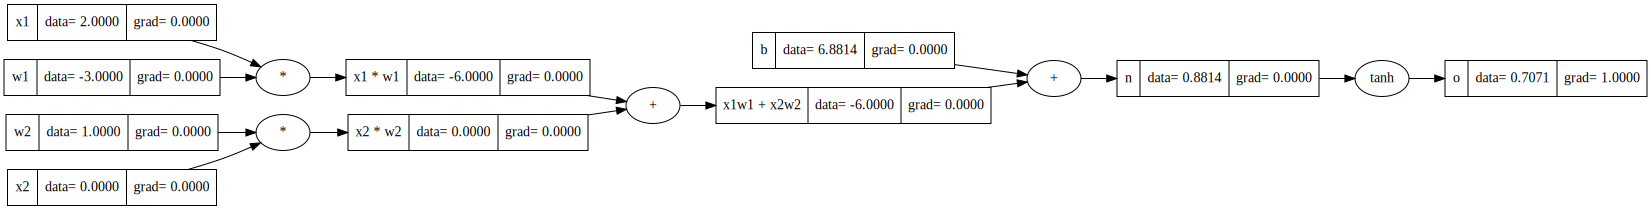

In [210]:
drawgraph(o)

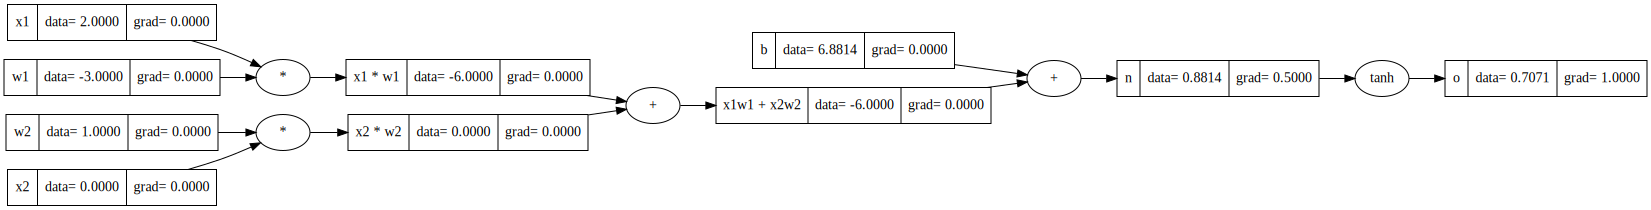

In [211]:
o.backpropogate()
drawgraph(o)

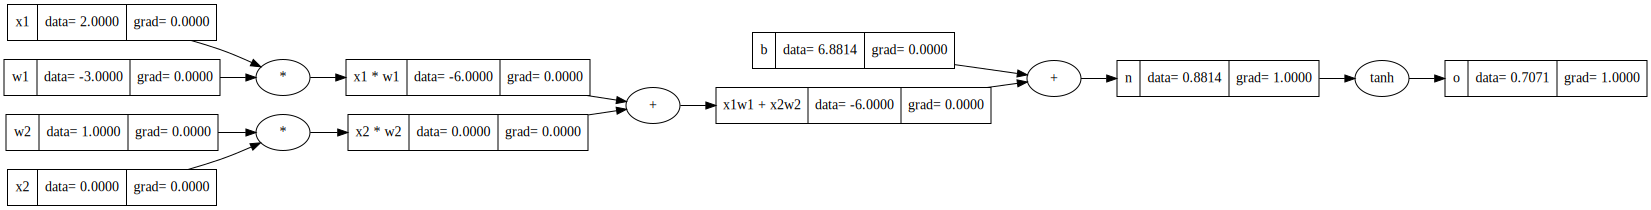

In [212]:
_ = o.backpropogate()
drawgraph(o)

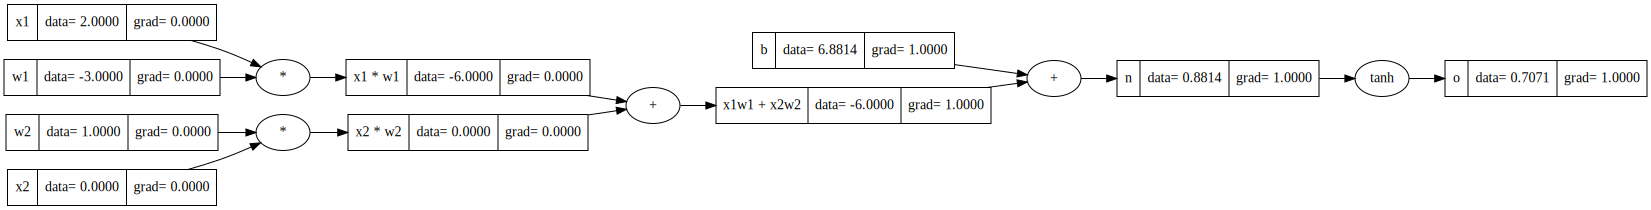

In [213]:
n.backpropogate()
drawgraph(o)

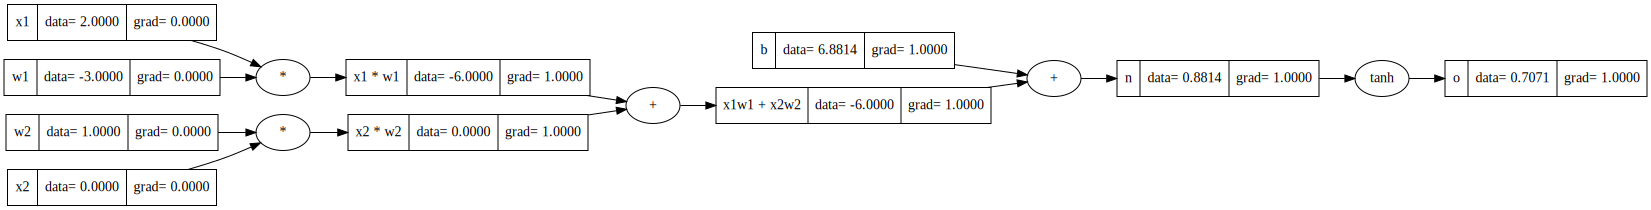

In [214]:
x1w1x2w2.backpropogate()
drawgraph(o)

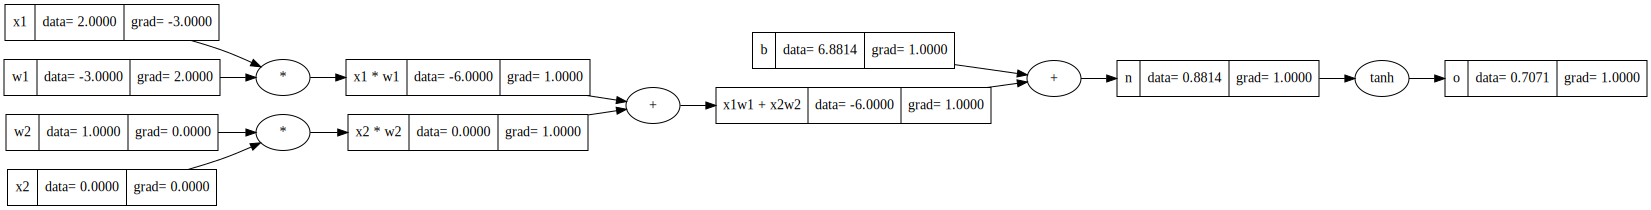

In [215]:
x1w1.backpropogate()
drawgraph(o)

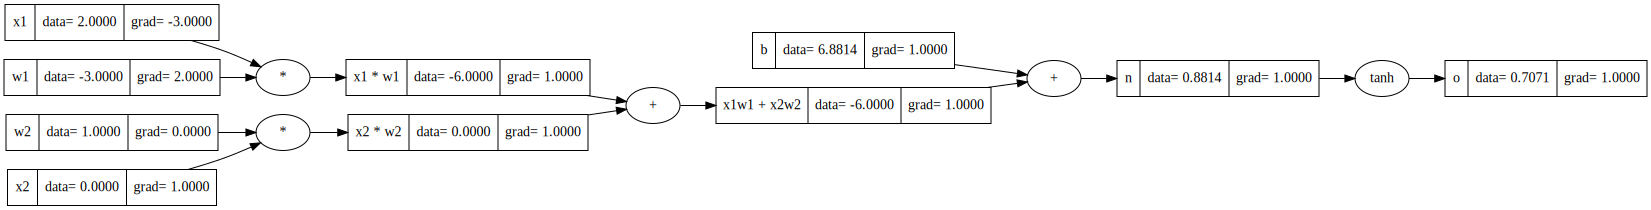

In [216]:
x2w2.backpropogate()
drawgraph(o)

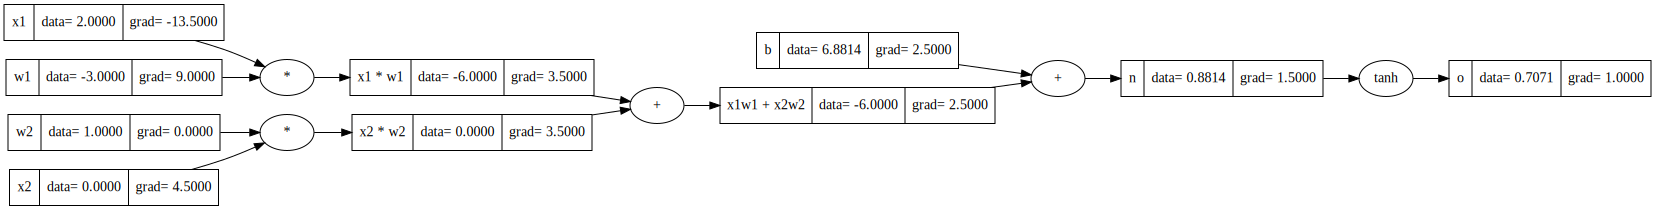

In [217]:
vi = o.backprop()

drawgraph(o)




# Implement a neuron

# Implment a Neuron

![neuron](neuron.png)

In [218]:
# x = [x1, x2, x3]
# w = [w1, w2, w3]
# y = activation(x1*w1 + x2w2 + x3w3 + b)

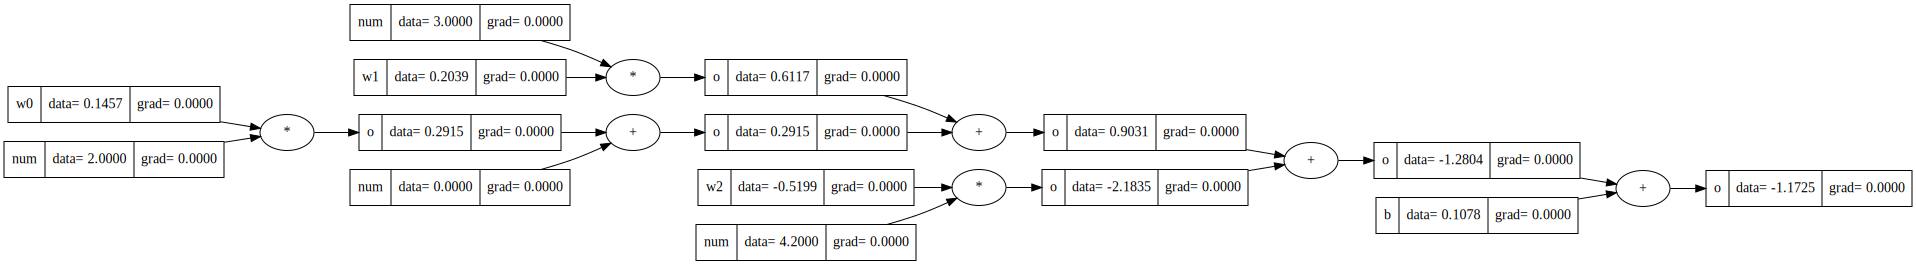

In [219]:
class Neuron:
    def __init__(self, nin: int):
        self.x = 0.0
        self.w = [Value(random.uniform(-1, 1), 'w{}'.format(i)) for i in range(nin)]
        self.b = Value(random.uniform(-1, 1), 'b')
        
    def __call__(self, data):
        
        self.x = data
        y = 0.0
        for x, w in zip(data, self.w):
            y += x * w
        
        y += self.b
        y.activate('tanh')
        return y
    

x = [2.0, 3.0, 4.2]

n1 = Neuron(len(x))
n1 = n1(x)

drawgraph(n1)

# Create a 1 layer using multiple Neurons

In [220]:
class Layer:
     def __init__(self):
            

SyntaxError: unexpected EOF while parsing (1574633436.py, line 3)

# Scrap 


In [ ]:
x1 = Value(2.0, 'x1')
x2 = Value(0.0, 'x2')
w1 = Value(-3.0, 'w1')
w2 = Value(1.0, 'w2')
b = Value(6.8813735870195432, 'b')

x1w1 = x1 * w1; x1w1.label = 'x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label= 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.activate('tanh')
o.grad = 1.0
drawgraph(o)

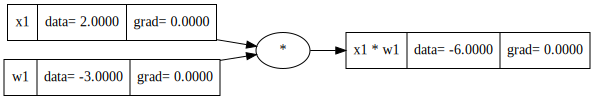

In [230]:
x1 = Value(2.0, 'x1')
w1 = Value(-3.0, 'w1')

x1w1 = x1 * w1; x1w1.label = 'x1 * w1'

drawgraph(x1w1)
